

# Neural Style Transfer with TensorFlow and Keras

This notebook showcases the implementation of Neural Style Transfer using TensorFlow and Keras. Neural Style Transfer is a technique that combines the content of one image with the style of another image to create visually appealing images.

## Overview
Neural Style Transfer involves extracting features from a pre-trained convolutional neural network and optimizing the generated image to match the content features of the content image and the style features of the style image. The notebook provides a step-by-step guide for implementing Neural Style Transfer, including functions for creating content and style models, computing content and style costs, and optimizing the generated image. It also includes code for reading and preprocessing the style and content images.

## VGG19 Model
The implementation is based on the VGG19 model, which is a popular choice for Neural Style Transfer due to its deep architecture and ability to capture both high-level and low-level features.

## Usage
To use this notebook, simply run the code cells in sequential order. Adjust the paths of the style and content images according to your requirements. The notebook allows for customization of parameters such as the weights for content and style costs, as well as the size of the generated image.

## Enjoy exploring the fascinating world of Neural Style Transfer!



## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
#from tensorflow.python.framework.ops import EagerTensor


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
for filename in os.listdir(os.getcwd()):
    file_path = os.path.join(os.getcwd(), filename)
    if os.path.isfile(file_path):
        os.remove(file_path)

# Delete all subdirectories within the folder
for subfolder in os.listdir(os.getcwd()):
    subfolder_path = os.path.join(os.getcwd(), subfolder)
    if os.path.isdir(subfolder_path):
        shutil.rmtree(subfolder_path)

os.makedirs("results")

In [ ]:
!git clone https://github.com/mohamedamine99/Neural-Style-Transfer-with-Python.git

Cloning into 'Neural-Style-Transfer-with-Python'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 95 (delta 33), reused 66 (delta 16), pack-reused 0
Receiving objects: 100% (95/95), 13.59 MiB | 30.98 MiB/s, done.
Resolving deltas: 100% (33/33), done.


## Functions definitions

In [ ]:
def create_content_model(model = None, layer_name = None, layer_index = None):
    """
    Create a model to extract content features from a given layer.

    Args:
    model (tf.keras.Model): The base model.
    layer_name (str): Name of the layer from which to extract content features.
    layer_index (int): Index of the layer from which to extract content features.

    Returns:
    tf.keras.Model: The content model.
    """

    content_model = Model(inputs = [model.input], outputs = [model.get_layer(layer_name).output])

    return content_model

In [ ]:
# TODO : try adding brackets
def create_style_model(model = None, layer_names = None):
    """
    Create a model to extract style features from multiple layers.

    Args:
    model (tf.keras.Model): The base model.
    layer_names (List[str]): Names of the layers from which to extract style features.

    Returns:
    tf.keras.Model: The style model.
    """

    outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
    style_model = Model(inputs = [model.input], outputs = outputs)
    return style_model

In [ ]:

def compute_content_cost(content_activations, generated_activations):
    """
    Compute the content cost between the content activations and generated activations.

    Args:
    content_activations (tf.Tensor): Activations of the content image.
    generated_activations (tf.Tensor): Activations of the generated image.

    Returns:
    tf.Tensor: The content cost.
    """


    cost = tf.reduce_mean(tf.square(content_activations - generated_activations)) / 4
    return cost



In [ ]:

def compute_gram(A):
    """
    Compute the Gram matrix of a given tensor.

    Args:
    A (tf.Tensor): The input tensor.

    Returns:
    tf.Tensor: The Gram matrix.
    """

    gram = tf.matmul(A , tf.transpose(A))
    return gram

In [ ]:

def compute_layer_style_cost(style_activation, generated_activation):
    """
    Compute the style cost between a single style activation and generated activation.

    Args:
    style_activation (tf.Tensor): Style activation.
    generated_activation (tf.Tensor): Generated activation.

    Returns:
    tf.Tensor: The style cost for the layer.
    """


    # get shapes
    #print(style_activation.shape)
    height, width, channels = style_activation.shape[-3:]
    # unroll and reshape and transpose activations , have them have the following shape (nc, n_h*n_w) : (channels, height * width)
    # prepare them to calculate gram matrices
    a_s_unrolled = tf.transpose(tf.reshape(style_activation, shape = [-1, channels]))
    a_g_unrolled = tf.transpose(tf.reshape(generated_activation, shape = [-1, channels]))

    # compute style and generated GRAM matrices
    gram_g = compute_gram(a_g_unrolled)
    gram_s = compute_gram(a_s_unrolled)

    layer_cost = tf.reduce_sum(tf.square(gram_s - gram_g)) / (2 * channels * height * width) ** 2
    return layer_cost

    #cost = tf.reduce_mean(tf.square(gram_s - gram_g))
    #cost = cost / 4
    #return cost

In [ ]:
def compute_style_cost(style_activations = None, generated_activations = None, layer_weights = None):
    """
    Compute the total style cost across multiple layers.

    Args:
    style_activations (List[tf.Tensor]): List of style activations.
    generated_activations (List[tf.Tensor]): List of generated activations.
    layer_weights (List[float]): List of weights for each layer.

    Returns:
    tf.Tensor: The total style cost.
    """


    style_cost = 0
    if layer_weights == None:
        layer_weights = [1 for layer in style_activations]

    #print(f'{layer_weights=}')
    for i, (style_activation, generated_activation, weight) in enumerate(zip(style_activations, generated_activations, layer_weights)):

        #print(f'Style Layer index : -{i}- ')#, end = ' ')
        layer_style_cost = compute_layer_style_cost(style_activation, generated_activation)
        style_cost += weight * layer_style_cost

    return style_cost


In [ ]:

@tf.function()
def compute_total_cost(content_cost, style_cost, alpha = 10, beta = 40):
    """
    Compute the total cost by combining the content and style costs.

    Args:
    content_cost (tf.Tensor): The content cost.
    style_cost (tf.Tensor): The style cost.
    alpha (float): Weight for the content cost.
    beta (float): Weight for the style cost.

    Returns:
    tf.Tensor: The total cost.
    """

    return alpha * content_cost + beta * style_cost


In [ ]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

## Main Implementation

### Initializations

(400, 400, 3)
(1, 400, 400, 3)


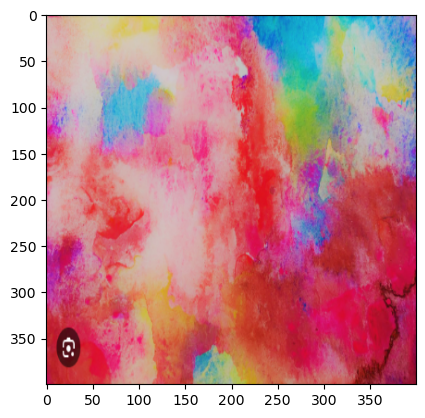

In [ ]:

# Syle imge reading and preprocessing
img_size = 400

# Style image initialization
style_img_path = os.path.join('.','Neural-Style-Transfer-with-Python/style imgs/abstract art style 2.PNG')

style_image =  cv2.resize(cv2.imread(style_img_path), (img_size, img_size))
print(style_image.shape)
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
style_image_rgb = cv2.cvtColor(style_image[0].numpy(), cv2.COLOR_BGR2RGB)
plt.imshow(style_image_rgb)
#plt.show()


(400, 400, 3)
(400, 400, 3)
tf.Tensor([160 165 164], shape=(3,), dtype=uint8)


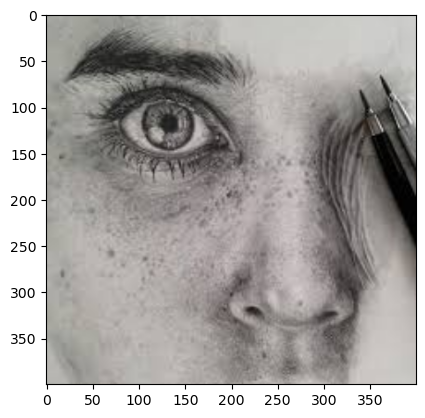

In [ ]:
# content image initialization
content_img_path = os.path.join('.','Neural-Style-Transfer-with-Python','content imgs', 'eye.jpg')
content_image =  cv2.resize(cv2.imread(content_img_path), (img_size, img_size))
print(content_image.shape)
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

# display purposes only
content_image_rgb = cv2.cvtColor(content_image[0].numpy(), cv2.COLOR_BGR2RGB)
print(content_image_rgb.shape)
print(content_image[0, 20 ,20])
plt.imshow(content_image_rgb)

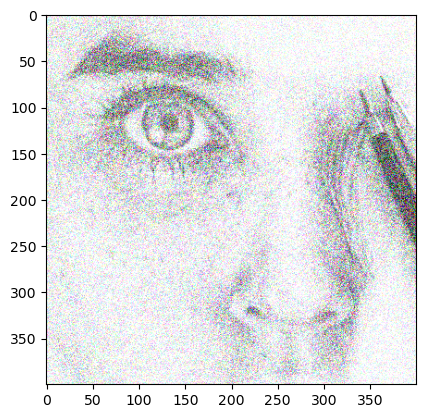

In [ ]:
# initialize and preprocess generated image
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image_preprocessed = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image_preprocessed = tf.Variable(generated_image_preprocessed, tf.float32)
plt.imshow(generated_image_preprocessed[0].numpy())


In [ ]:
# preprocess style and content images
content_img_preprocessed = tf.image.convert_image_dtype(content_image, tf.float32)
style_img_preprocessed = tf.image.convert_image_dtype(style_image, tf.float32)

In [ ]:
vgg_input_shape = (400, 400, 3)
model = VGG19(input_shape = vgg_input_shape, include_top= False, weights = 'imagenet')
model.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# initiaalize models
c_m = create_content_model(model = model, layer_name = 'block2_conv2', layer_index = None)

layer_names = layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                             'block4_conv1', 'block5_conv1']
s_m = create_style_model(model = model, layer_names = layer_names)
# initialize activations for both style and content
a_c = c_m(content_img_preprocessed)
a_s = s_m(style_img_preprocessed)

# initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


In [ ]:
#s_m.summary()
print(len(s_m(generated_image_preprocessed)))
print(s_m.output_shape)
print(len(a_s))

5
[(None, 400, 400, 64), (None, 200, 200, 128), (None, 100, 100, 256), (None, 50, 50, 512), (None, 25, 25, 512)]
5


### Train loop

Epoch : 0 -- Cost = 745960.125
Epoch : 1000 -- Cost = 2291.261474609375
Epoch : 2000 -- Cost = 881.2225341796875
Epoch : 3000 -- Cost = 509.72509765625
Epoch : 4000 -- Cost = 348.255126953125
Epoch : 5000 -- Cost = 262.8916931152344
Epoch : 6000 -- Cost = 210.44070434570312
Epoch : 7000 -- Cost = 174.9322052001953
Epoch : 8000 -- Cost = 152.5537872314453
Epoch : 9000 -- Cost = 137.17019653320312
Epoch : 10000 -- Cost = 126.54228210449219
Epoch : 11000 -- Cost = 119.09664916992188
Epoch : 12000 -- Cost = 121.8673095703125
Epoch : 13000 -- Cost = 108.399658203125
Epoch : 14000 -- Cost = 104.24485778808594
Compute time 16 mins 43


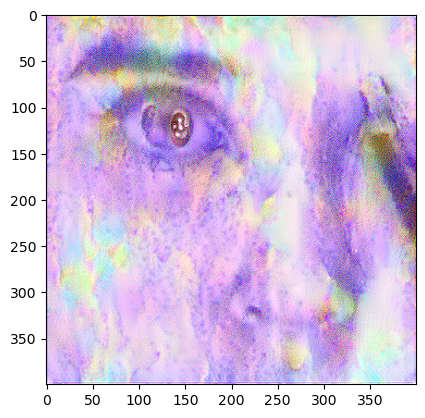

In [ ]:
beg = time.time()
for i in range(15000):

    with tf.GradientTape() as tape:
        # generated activations here generated_img
        a_g = c_m(generated_image_preprocessed)
        content_cost = compute_content_cost(a_c, a_g)

        a_g = s_m(generated_image_preprocessed)
        style_cost = compute_style_cost(a_s, a_g, layer_weights = None)

        cost = compute_total_cost(content_cost, style_cost, alpha = 100, beta = 150)
        #print(f'--Cost = {float(cost.numpy())}', end =' ')

    # compute and apply gradients
    grads = tape.gradient(cost, generated_image_preprocessed)
    optimizer.apply_gradients([(grads, generated_image_preprocessed)])

    # add 0_1 clipping here
    generated_image_preprocessed.assign(clip_0_1(generated_image_preprocessed))
    if i % 1000 == 0:
        print(f'Epoch : {i} -- Cost = {float(cost.numpy())}')
        # get the bgr image with [0..1] float values in a numpy type
        bgr_numpy_img = generated_image_preprocessed[0].numpy()

        cv2_img = np.round(np.multiply(bgr_numpy_img, 255)).astype(np.uint8)
        cv2.imwrite(f'./results/{i}.png', cv2_img)


# bgr display
plt.imshow(generated_image_preprocessed[0].numpy())
end = time.time()
print(f'Compute time {int(end - beg) // 60} mins {int(end - beg) % 60}')

(400, 400, 3)
1.0


True

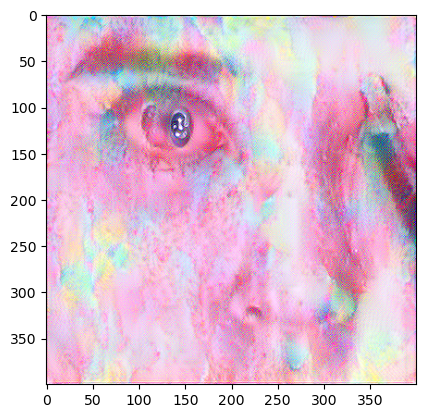

In [ ]:
# rgb display
plt.imshow(generated_image_preprocessed[0].numpy()[..., ::-1])
plt.savefig('figure.png')
print(generated_image_preprocessed[0].numpy()[..., ::-1].shape)
print(np.max(generated_image_preprocessed[0].numpy()))
cv2.imwrite('img.jpg', generated_image_preprocessed[0].numpy())